In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.utils.data as data_utils

if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
device_ = torch.device(device)
print(device, " in use")

torch.autograd.set_detect_anomaly(True)

cuda  in use


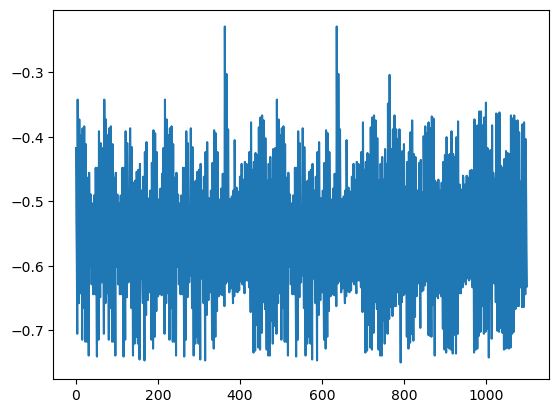

In [13]:
states_1 = np.load('data_1.npy')
states_2 = np.load('data_2.npy')
states_3 = np.load('data_3.npy')
states_4 = np.load('data_4.npy')

states = np.concatenate((states_1, states_2, states_3, states_4), axis=0)

# print the array
plt.plot([row[3] for row in states])

In [14]:
obs_space = len(states[0])
obs_space

10

# Attempt 1 
Simple model which will take state and precit next state. loss function is how good predictions are wrt collected dataset

# Dataloader

In [15]:
# Define the dataset class
class Dataset(data_utils.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        x = self.data[index, :]
        y = self.data[index + 1, :]
        return x, y

    def __len__(self):
        return 10

In [16]:
states = Dataset(states)

# Create a DataLoader object for the dataset
batch_size = 8
shuffle = False
dataloader = data_utils.DataLoader(states, batch_size=batch_size, shuffle=shuffle)


In [17]:
min_values = torch.tensor([-0.37, -1.53, -0.09, -1.18, -0.39 , -0.79, -1.53, -0.10, -1.18, -0.76], dtype=torch.float32)
max_values = torch.tensor([ 0.79, 0.48, 2.11, 0.92, 0.76,  0.37, 0.48, 2.12, 0.93, 0.39], dtype=torch.float32)

# Model

In [18]:
class ActorNet(nn.Module):
    def __init__(self, state_dim):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, state_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = 2*torch.tanh(self.fc3(x))
        return x


In [19]:
Actor = ActorNet(obs_space).to(device)

lr = 0.0001
Actor_optim = optim.Adam(Actor.parameters(), lr = lr)

criterion = nn.MSELoss()

# Train

In [20]:
running_loss = 0.0
for epoch in range(1000):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        Actor_optim.zero_grad()
        
        x_clamped = torch.clamp(x, min_values, max_values)
        y_pred = Actor(x_clamped.to(device).float())


        loss = criterion(y_pred, y.to(device).float())

        loss.backward()

        Actor_optim.step()

        running_loss += loss.item()
    
    if (epoch)%100 == 0:
        print(f"Epoch {epoch}, loss: {running_loss/len(dataloader)}")



Epoch 0, loss: 0.28862062096595764
Epoch 100, loss: 0.00722725666128099
Epoch 200, loss: 0.0042192405089735985
Epoch 300, loss: 0.0025400723970960826
Epoch 400, loss: 0.0021422234131023288
Epoch 500, loss: 0.001894535860628821
Epoch 600, loss: 0.0016655194340273738
Epoch 700, loss: 0.001472140065743588
Epoch 800, loss: 0.0013338507997104898
Epoch 900, loss: 0.0012303606417845003


In [45]:
Actor(torch.tensor([ 0.07674193, -0.4862361 ,  0.91115403, -0.41728997, -0.078192  ,
         0.09514999, -0.21940398,  0.84220791, -0.61355805, -0.09046412]).to(device))

tensor([-0.2713,  0.3520, -0.0701,  0.2372,  0.1134,  0.0530,  0.1659,  0.0387,
        -0.3919, -0.0480], device='cuda:0', grad_fn=<MulBackward0>)

# Evaluate

In [21]:
eval_states = np.load('data_5.npy')
eval_states = Dataset(eval_states)

dataloader = data_utils.DataLoader(eval_states, batch_size=batch_size, shuffle=shuffle)

In [22]:
Actor.eval()

total_loss = 0.0
num_correct = 0

with torch.no_grad():
    for states, next_state in dataloader:
        next_state_pred = Actor(states.to(device).float())
        loss = criterion(next_state_pred, next_state.to(device).float())
        total_loss += loss.item() * len(states)
        
avg_loss = total_loss / len(dataloader)

print(f"Average loss: {avg_loss:.4f}")


Average loss: 0.0086


# Save Model

In [71]:
torch.save(Actor.state_dict(), 'model_weights.pth')